<a href="https://colab.research.google.com/github/Afkar5115/Visi_Komputer_2025/blob/main/Jobsheet_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JOBSHEET 03: TEKNIK REGRESI GAMBAR


## Praktikum



### D1 : Regresi dari Citra Sintetis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Generator untuk 1 sampel gambar
def make_sample(img_size=64, min_r=5, max_r=20):
    # Radius acak
    r = np.random.randint(min_r, max_r + 1)
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    # Titik pusat acak
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)
    # Menggambar lingkaran putih
    cv2.circle(img, (cx, cy), r, (255,), -1)
    img = (img / 255.0).astype(np.float32)
    # Dibuat 3 channel agar kompatibel dengan model CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

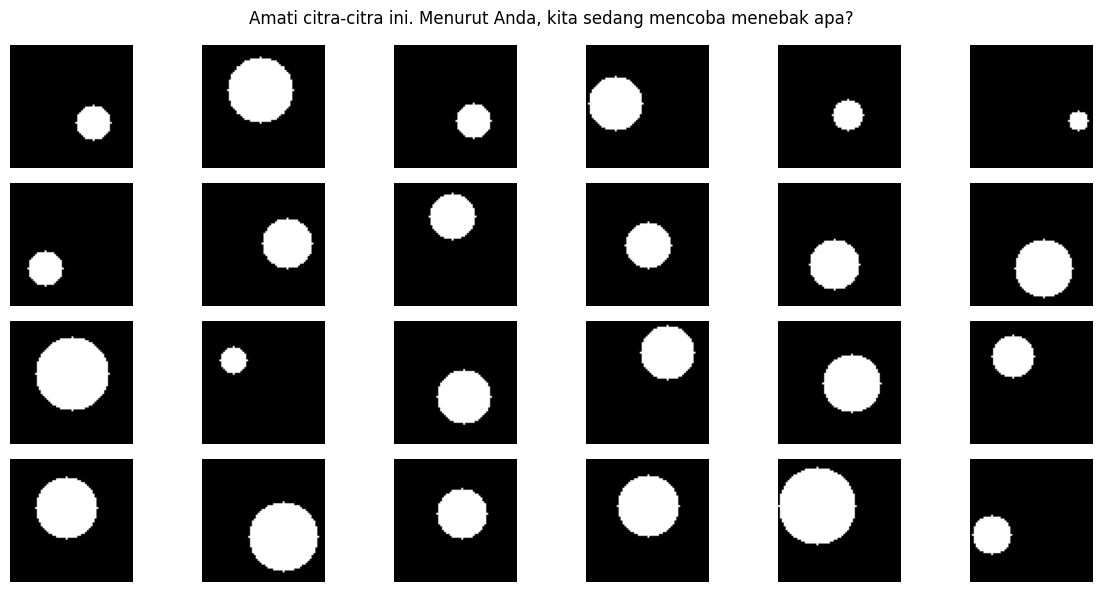

In [2]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Tampilkan grid gambar tanpa label
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

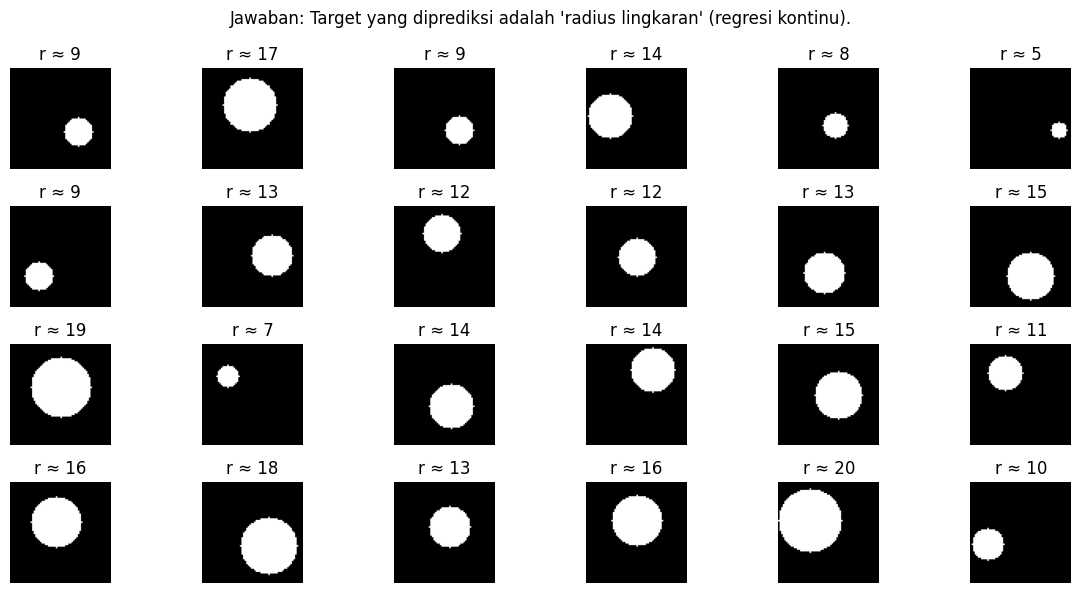

In [3]:
# Tampilkan kembali, sekarang dengan label radius
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

In [4]:
# Siapkan dataset lebih besar untuk training
N = 3000
X_list, y_list, c_list = zip(*[make_sample() for _ in range(N)])
X = np.array(X_list, dtype=np.float32)
y = np.array(y_list, dtype=np.float32)

# Bagi dataset
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # Output regresi (1 nilai kontinu)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=0)

print("Pelatihan selesai.")

Pelatihan selesai.


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
MAE=0.964 | RMSE=1.188 | R²=0.932


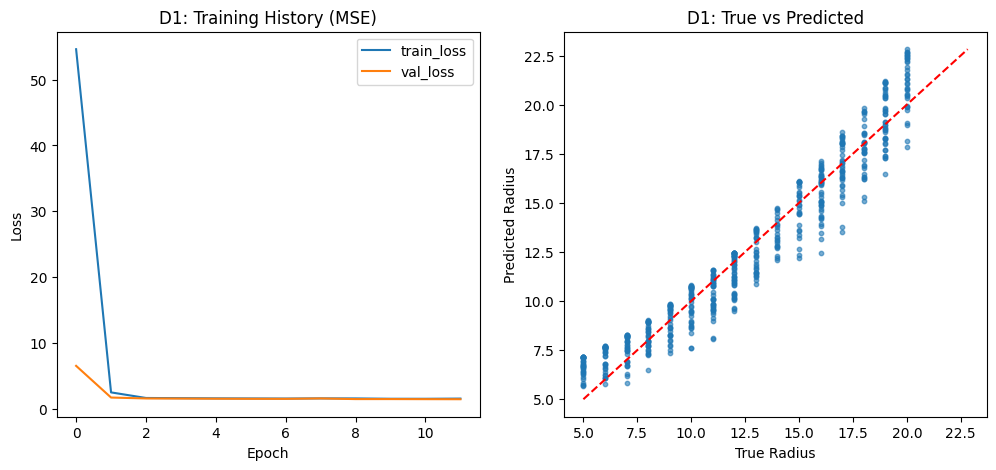

In [5]:
# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

# Plot loss history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Scatter plot True vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

#### Tugas Kecil

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras import layers, models
import tensorflow as tf

# === 1. Fungsi generator dasar ===
def make_sample(img_size=64, min_r=5, max_r=20, noise=False):
    r = np.random.randint(min_r, max_r + 1)
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)
    cv2.circle(img, (cx, cy), r, (255,), -1)

    if noise:
        img = cv2.GaussianBlur(img, (5, 5), 0)
        noise_map = np.random.normal(0, 20, img.shape).astype(np.float32)
        img = np.clip(img + noise_map, 0, 255)

    img = (img / 255.0).astype(np.float32)
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

# === Fungsi pembuat dataset ===
def make_dataset(N=3000, img_size=64, min_r=5, max_r=20, noise=False, multi=False):
    if multi:
        data = []
        for _ in range(N):
            img3, r, (cx, cy) = make_sample(img_size, min_r, max_r, noise)
            data.append((img3, np.array([r, cx, cy], dtype=np.float32)))
        X = np.array([d[0] for d in data])
        y = np.array([d[1] for d in data])
    else:
        X, y, _ = zip(*[make_sample(img_size, min_r, max_r, noise) for _ in range(N)])
        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.float32)
    return X, y

# === Fungsi pembuatan dan evaluasi model ===
def build_and_eval(X, y, output_dim=1, title="Model"):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

    model = models.Sequential([
        layers.Input((64, 64, 3)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(output_dim)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=8, batch_size=64, verbose=0)

    y_pred = model.predict(Xte)

    if output_dim == 1:
        y_pred = y_pred.ravel()
        mae = mean_absolute_error(yte, y_pred)
        rmse = np.sqrt(np.mean((yte - y_pred) ** 2))
        r2 = r2_score(yte, y_pred)
        print(f"\n[{title}]")
        print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")
    else:
        mae = np.mean(np.abs(yte - y_pred), axis=0)
        rmse = np.sqrt(np.mean((yte - y_pred) ** 2, axis=0))
        r2 = [r2_score(yte[:, i], y_pred[:, i]) for i in range(output_dim)]
        print(f"\n[{title}]")
        print(f"MAE [r,cx,cy] = {mae}")
        print(f"RMSE [r,cx,cy] = {rmse}")
        print(f"R² [r,cx,cy] = {r2}")

# === EKSPERIMEN 1: Radius lebih lebar (8–28) ===
X, y = make_dataset(min_r=8, max_r=28)
build_and_eval(X, y, output_dim=1, title="Eksperimen 1 - Radius 8–28")

# === EKSPERIMEN 2: Tambahkan noise Gaussian & blur ===
X, y = make_dataset(noise=True)
build_and_eval(X, y, output_dim=1, title="Eksperimen 2 - Dengan Noise/Blur")

# === EKSPERIMEN 3: Multi-output [r, cx, cy] ===
X, y = make_dataset(multi=True)
build_and_eval(X, y, output_dim=3, title="Eksperimen 3 - Multi-output [r, cx, cy]")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

[Eksperimen 1 - Radius 8–28]
MAE=0.789 | RMSE=0.968 | R²=0.975
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

[Eksperimen 2 - Dengan Noise/Blur]
MAE=0.950 | RMSE=1.158 | R²=0.934
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

[Eksperimen 3 - Multi-output [r, cx, cy]]
MAE [r,cx,cy] = [1.1428388 5.69667   5.9531255]
RMSE [r,cx,cy] = [1.4638281 7.3082747 7.2861648]
R² [r,cx,cy] = [0.9016450047492981, 0.5836995840072632, 0.6253472566604614]


### D2 : Menebak Umur Manusia dari Foto Wajah

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"mmumtazaalafkar","key":"5620631b0815081ee50ca7c9f3ff037f"}'}

In [8]:
import os, shutil

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print(" .ı kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


In [9]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
replace /content/utk/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


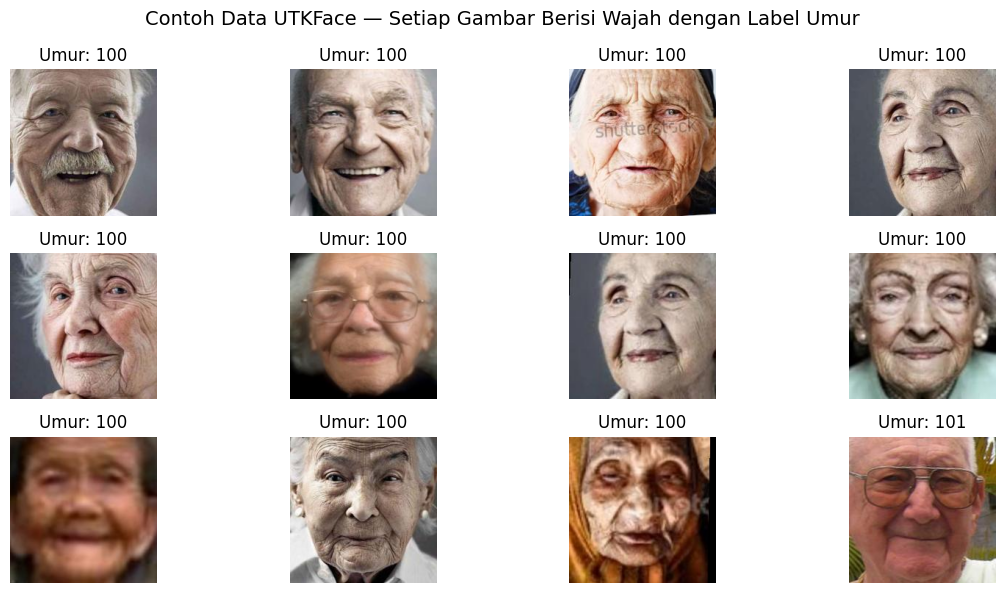

In [10]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import os

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160

def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # output tunggal: umur

model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

model.summary()


Hardware: GPU


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 63s 128ms/step - loss: 333.7057 - mae: 13.4354 - val_loss: 159.7446 - val_mae: 9.6370 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 152.5336 - mae: 9.1752 - val_loss: 145.4594 - val_mae: 9.0413 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 145.2153 - mae: 8.9019 - val_loss: 143.0933 - val_mae: 8.9847 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 141.1826 - mae: 8.7603 - val_loss: 140.1596 - val_mae: 8.8449 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 139.0010 - mae: 8.6224 - val_loss: 137.8333 - val_mae: 8.7371 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 136.0377 - mae: 8.5202 - val_loss: 135.5146 - val_mae: 8.6115 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 135.3516 - mae: 8.5460 - val_loss: 134.9940 - va

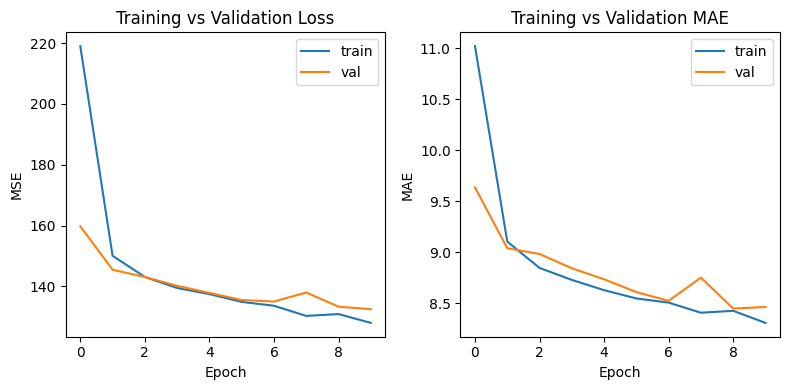

In [13]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 46s 99ms/step - loss: 188.2319 - mae: 10.0890 - val_loss: 162.6403 - val_mae: 9.2793 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 79.5657 - mae: 6.6113 - val_loss: 117.2546 - val_mae: 7.8995 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 53.1332 - mae: 5.4553 - val_loss: 106.3372 - val_mae: 7.5034 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 37.1175 - mae: 4.6112 - val_loss: 111.2953 - val_mae: 7.5086 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 29.5081 - mae: 4.1033 - val_loss: 104.9342 - val_mae: 7.3514 - learning_rate: 1.0000e-04


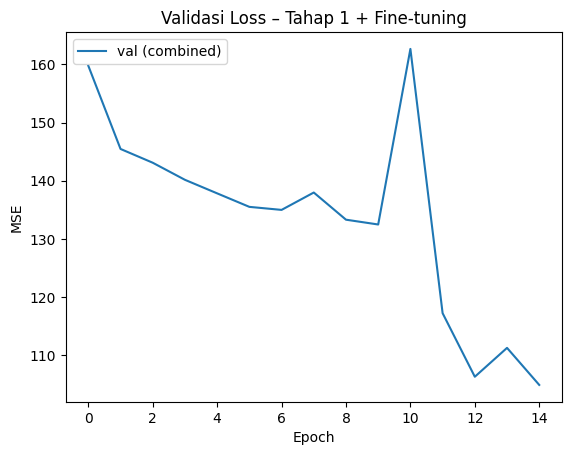

In [14]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


MAE = 7.35 tahun
RMSE = 10.24 tahun
R² = 0.736


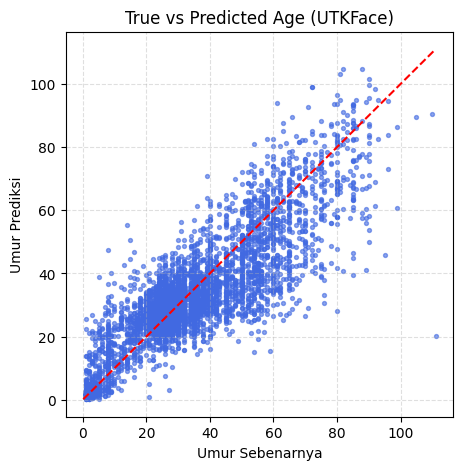

In [15]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R² = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

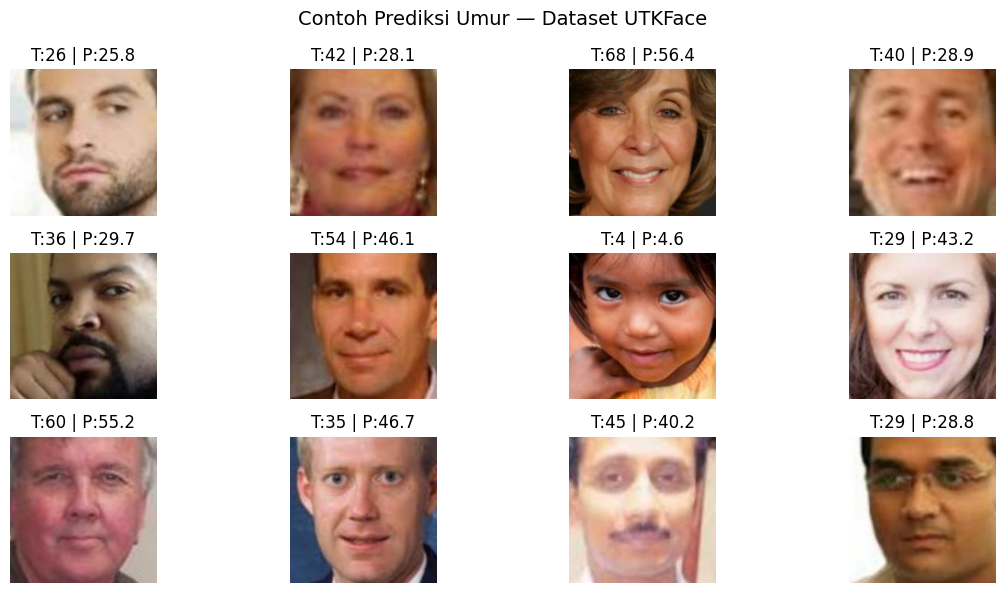

In [16]:
import random

sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12, 6))

for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

#### Tugas Kecil


🚀 Memulai pengerjaan Tantangan Mini D2...

[Tantangan 1] Menyiapkan Data Augmentation...
Dataset dengan augmentasi telah dibuat.
Untuk melatih ulang, hapus tanda '#' pada baris 'model.fit' di bawah dan jalankan.

[Tantangan 2] Menyiapkan Optimizer dan Learning Rate Schedule Baru...
Model telah di-compile ulang dengan optimizer SGD.
Anda bisa melatihnya kembali untuk melihat perbandingan stabilitasnya.

[Tantangan 3] Menganalisis Error per Kelompok Umur...
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step

>>> Hasil Analisis MAE per Kelompok Umur:
age_group
0-10      4.162103
11-20     7.783828
21-30     4.843521
31-40     6.250073
41-50     9.796954
51-60    12.223548
61-70    13.650413
71-80    14.499224
80+      15.602398
Name: absolute_error, dtype: float32

💡 Kelompok dengan error prediksi terbesar adalah: '80+'


/tmp/ipython-input-627973327.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_per_group = df_results.groupby('age_group')['absolute_error'].mean()


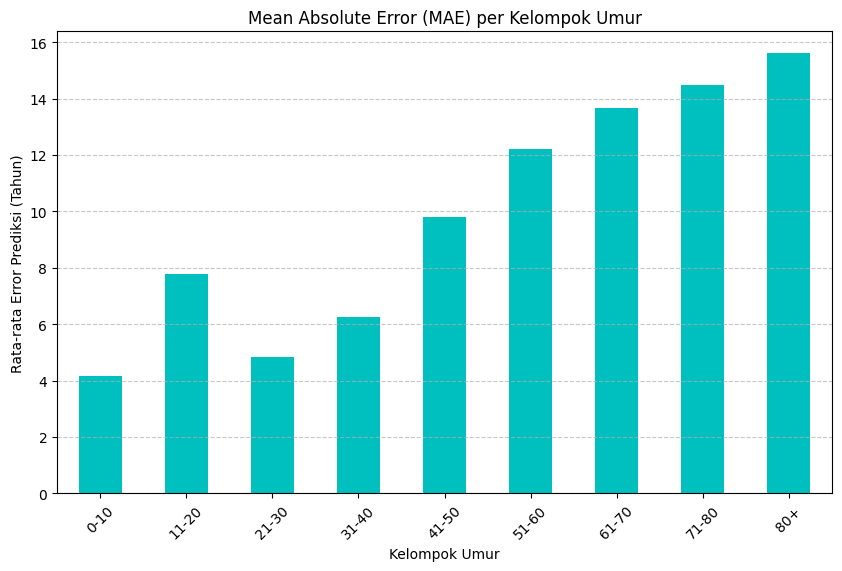


[Tantangan 4] Uji Model pada Foto Anda Sendiri...
Silakan unggah sebuah foto wajah yang jelas.


Saving Foto pribadi.jpg to Foto pribadi.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


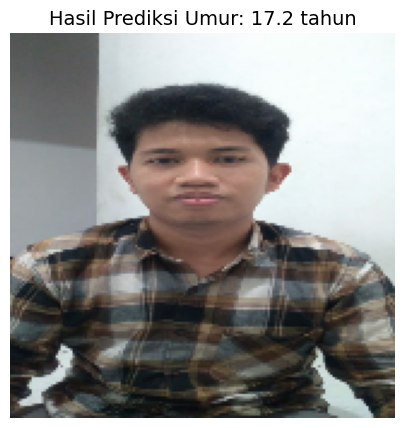


✅ Semua tantangan telah selesai dieksekusi.


In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from google.colab import files
import os

# ==============================================================================
# CATATAN: Pastikan Anda telah menjalankan kode utama Praktikum D2 sebelumnya.
# Variabel berikut harus sudah ada di environment Anda:
# model, train_files, y_train, test_files, y_test, test_ds, IMG_SIZE
# ==============================================================================

print("🚀 Memulai pengerjaan Tantangan Mini D2...")

# ------------------------------------------------------------------------------
## Tantangan 1: Menambahkan Data Augmentation
# ------------------------------------------------------------------------------
# Tujuan: Membuat model lebih tahan terhadap variasi gambar (rotasi, zoom, dll.)
#         dan biasanya dapat menurunkan MAE pada data uji.

print("\n[Tantangan 1] Menyiapkan Data Augmentation...")

# Definisikan lapisan augmentasi
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomContrast(0.1),
  tf.keras.layers.RandomBrightness(0.1),
], name="data_augmentation")

# Buat dataset training baru yang menerapkan augmentasi
# Asumsikan 'load_img' adalah fungsi dari praktikum utama
train_ds_augmented = tf.data.Dataset.from_tensor_slices((train_files, y_train))\
    .map(load_img, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(64)\
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)\
    .prefetch(tf.data.AUTOTUNE)

print("Dataset dengan augmentasi telah dibuat.")
print("Untuk melatih ulang, hapus tanda '#' pada baris 'model.fit' di bawah dan jalankan.")
# UNCOMMENT UNTUK MELATIH ULANG:
# history_augmented = model.fit(
#     train_ds_augmented,
#     validation_data=test_ds,
#     epochs=10 # Latih untuk beberapa epoch tambahan
# )
# print("Pelatihan dengan augmentasi selesai. Anda bisa evaluasi MAE-nya sekarang.")


# ------------------------------------------------------------------------------
## Tantangan 2: Mengubah Optimizer dan Learning Rate Schedule
# ------------------------------------------------------------------------------
# Tujuan: Menguji apakah optimizer yang berbeda atau jadwal learning rate
#         dapat membuat pelatihan lebih stabil dan konvergen lebih baik.

print("\n[Tantangan 2] Menyiapkan Optimizer dan Learning Rate Schedule Baru...")

# Definisikan jadwal learning rate yang akan menurun seiring waktu
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

# Compile ulang model dengan optimizer SGD dan jadwal LR yang baru
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
    loss='mse',
    metrics=['mae']
)

print("Model telah di-compile ulang dengan optimizer SGD.")
print("Anda bisa melatihnya kembali untuk melihat perbandingan stabilitasnya.")


# ------------------------------------------------------------------------------
## Tantangan 3: Menganalisis Error per Kelompok Umur
# ------------------------------------------------------------------------------
# Tujuan: Mengidentifikasi kelompok umur mana yang paling sulit diprediksi oleh model.

print("\n[Tantangan 3] Menganalisis Error per Kelompok Umur...")

# Lakukan prediksi pada data tes (jika belum ada)
y_pred = model.predict(test_ds).ravel()

# Buat DataFrame untuk analisis
df_results = pd.DataFrame({'true_age': y_test, 'predicted_age': y_pred})
df_results['absolute_error'] = abs(df_results['true_age'] - df_results['predicted_age'])

# Buat kategori kelompok umur
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 120]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']
df_results['age_group'] = pd.cut(df_results['true_age'], bins=bins, labels=labels, right=True)

# Hitung rata-rata error (MAE) untuk setiap kelompok
mae_per_group = df_results.groupby('age_group')['absolute_error'].mean()

print("\n>>> Hasil Analisis MAE per Kelompok Umur:")
print(mae_per_group)

highest_error_group = mae_per_group.idxmax()
print(f"\n💡 Kelompok dengan error prediksi terbesar adalah: '{highest_error_group}'")

# Visualisasi hasil analisis
mae_per_group.plot(kind='bar', figsize=(10, 6), color='c')
plt.title('Mean Absolute Error (MAE) per Kelompok Umur')
plt.ylabel('Rata-rata Error Prediksi (Tahun)')
plt.xlabel('Kelompok Umur')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# ------------------------------------------------------------------------------
## Tantangan 4: Uji Model pada Wajah Sendiri
# ------------------------------------------------------------------------------
# Tujuan: Menguji performa model pada data yang benar-benar baru dan tidak
#         pernah dilihat sebelumnya (out-of-sample).

print("\n[Tantangan 4] Uji Model pada Foto Anda Sendiri...")
print("Silakan unggah sebuah foto wajah yang jelas.")

# Minta pengguna mengunggah file
uploaded = files.upload()

if not uploaded:
    print("Tidak ada file yang diunggah. Langkah ini dilewati.")
else:
    file_path = list(uploaded.keys())[0]

    # Membaca dan memproses gambar yang diunggah
    img_bytes = tf.io.read_file(file_path)
    img = tf.image.decode_image(img_bytes, channels=3)
    img_resized = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    # Normalisasi dan siapkan untuk prediksi
    img_for_pred = tf.expand_dims(img_resized, 0) / 255.0

    # Lakukan prediksi
    predicted_age = model.predict(img_for_pred)[0][0]

    # Tampilkan gambar dan hasil prediksi
    plt.figure(figsize=(5, 5))
    plt.imshow(img_resized.numpy().astype("uint8"))
    plt.axis('off')
    plt.title(f"Hasil Prediksi Umur: {predicted_age:.1f} tahun", fontsize=14)
    plt.show()

    # Hapus file yang diunggah agar tidak menumpuk
    os.remove(file_path)

print("\n✅ Semua tantangan telah selesai dieksekusi.")

### D3 : Menilai “Kepopuleran Hewan Peliharaan” dari Foto

In [1]:
from google.colab import files
files.upload()  # pilih kaggle.json dari komputer Anda
import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("    kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle.json to kaggle.json
✅ Kaggle API siap digunakan.


In [3]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1155, in competition_download_cli
    self.competition_download_files(competition, path, force, quiet)
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1123, in competition_download_files
    self.download_file(response, outfile, kaggle.http_client(), quiet, not force)
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 2147, in download_file
    response = http_client.call(
               ^^^^^^^^^^^^^^^^^
TypeError: KaggleHttpClient.call() got an unexpected keyword argument 'headers'
[/content/petfinder-pawpularity-score.zip]
  End-of-central-d

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

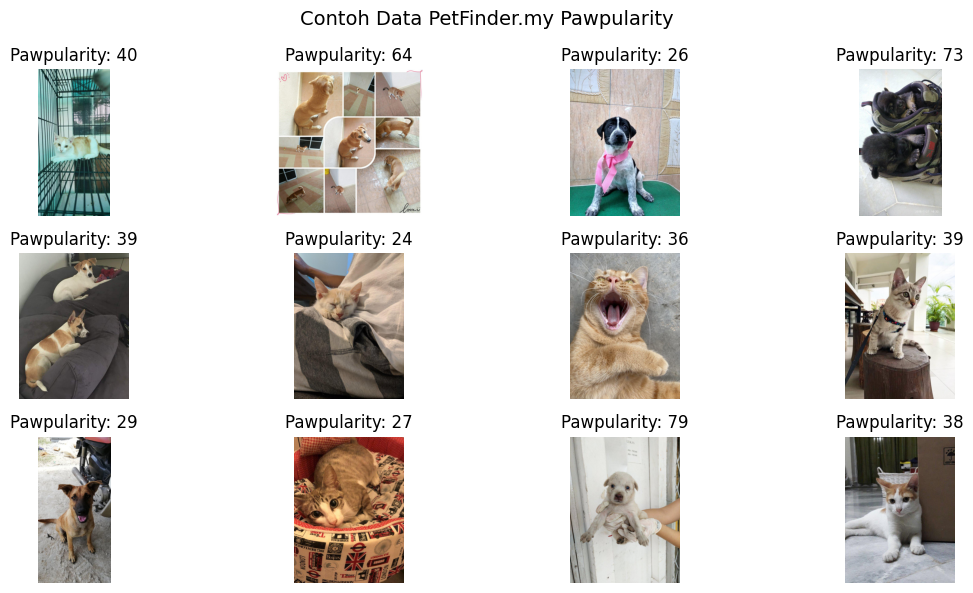

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

# Tambahkan tanda kurung pembuka di awal dan penutup di akhir
train_ds = (tf.data.Dataset.from_tensor_slices((train_df['path'],
                                              train_df['Pawpularity']))
            .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)
           )

val_ds = (tf.data.Dataset.from_tensor_slices((val_df['path'],
                                            val_df['Pawpularity']))
          .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(64).prefetch(tf.data.AUTOTUNE)
         )

print(f"Dataset siap digunakan: {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

Dataset siap digunakan: 7929 untuk training, 1983 untuk validasi.


In [6]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3,
restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=10,
callbacks=cb, verbose=1)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 114s 549ms/step - loss: 842.8703 - mae: 22.0054 - val_loss: 478.5045 - val_mae: 16.0164 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 80s 229ms/step - loss: 427.2127 - mae: 15.1319 - val_loss: 426.4414 - val_mae: 15.3263 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 77s 201ms/step - loss: 382.0883 - mae: 14.4600 - val_loss: 405.8212 - val_mae: 14.9973 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 212ms/step - loss: 371.6178 - mae: 14.2976 - val_loss: 391.7928 - val_mae: 14.5692 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step - loss: 371.6491 - mae: 14.3574 - val_loss: 379.6498 - val_mae: 14.1667 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 230ms/step - loss: 348.6087 - mae: 13.7162 - val_loss: 374.8698 - val_mae: 14.3511 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 243ms/step - loss: 355.6282 - mae: 13.9429 - val_

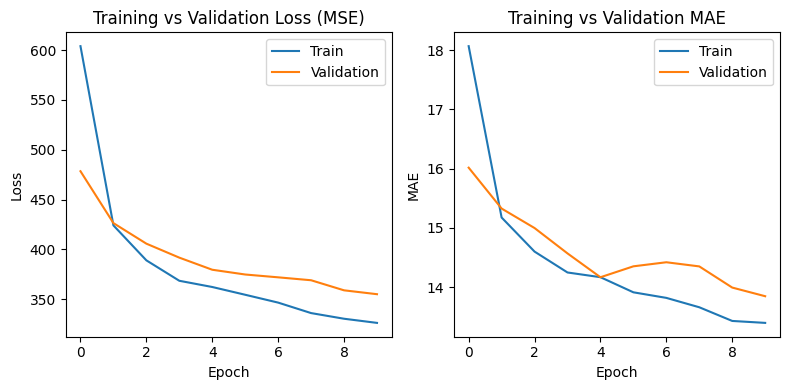

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()


MAE  = 13.85
RMSE = 18.84
R²   = 0.197


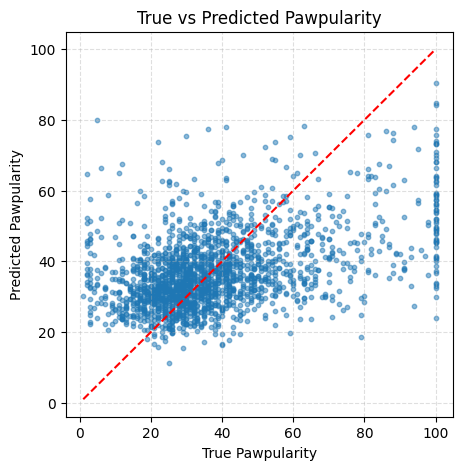

In [9]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for
batch in val_ds])
mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")
# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

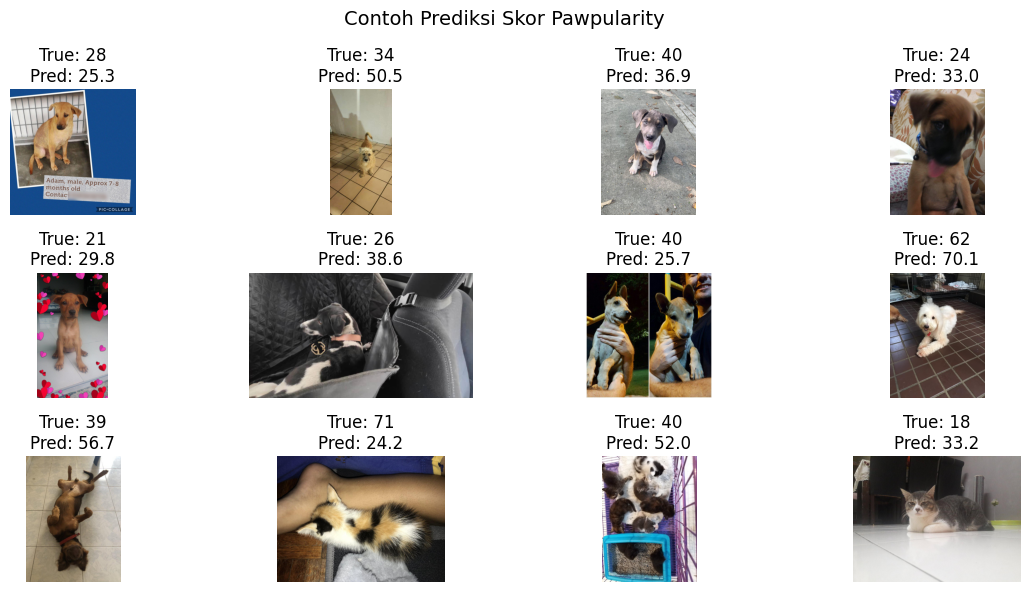

In [11]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)
plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
    # Tambahkan indentasi pada semua baris di bawah ini
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

#### Tugas Kecil

In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt
import cv2

# ==============================================================================
# CATATAN: Pastikan Anda telah menjalankan kode utama Praktikum D3 sebelumnya.
# Variabel berikut harus sudah ada:
# model, train_df, val_df, train_ds, val_ds, IMG_SIZE, load_image
# ==============================================================================

print("🚀 Memulai pengerjaan Tantangan Mini D3...")

# ------------------------------------------------------------------------------
## Tantangan 1: Menambahkan Data Augmentation
# ------------------------------------------------------------------------------
# Tujuan: Membuat model lebih generalis terhadap variasi gambar, yang
#         berpotensi meningkatkan performa (menurunkan MAE) pada data baru.

print("\n[Tantangan 1] Menyiapkan Data Augmentation...")

# Definisikan lapisan augmentasi
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

# Buat ulang dataset training dengan pipeline augmentasi
train_ds_augmented = (train_ds.unbatch()
                      .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
                      .batch(64)
                      .prefetch(tf.data.AUTOTUNE))

print("Dataset dengan augmentasi telah dibuat.")
print("Anda bisa melatih ulang model dengan dataset 'train_ds_augmented' untuk melihat perubahannya.")
# CONTOH: model.fit(train_ds_augmented, validation_data=val_ds, epochs=5)

# ------------------------------------------------------------------------------
## Tantangan 2: Menggunakan Arsitektur Model yang Berbeda (ResNet50)
# ------------------------------------------------------------------------------
# Tujuan: Membandingkan performa model yang berbeda. Arsitektur yang lebih
#         kompleks mungkin dapat menangkap fitur yang lebih baik, tetapi
#         juga lebih berat untuk dilatih.

print("\n[Tantangan 2] Membangun model dengan arsitektur ResNet50...")

# Bangun model baru menggunakan ResNet50 sebagai backbone
base_resnet = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_resnet.trainable = False # Freeze backbone

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs * 255.0) # Preprocessing khusus ResNet
x = base_resnet(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model_resnet = tf.keras.Model(inputs, outputs)

model_resnet.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Model ResNet50 siap dilatih. Anda bisa melatihnya dan membandingkan hasil MAE-nya dengan EfficientNetB0.")
# CONTOH: history_resnet = model_resnet.fit(train_ds, validation_data=val_ds, epochs=5)

# ------------------------------------------------------------------------------
## Tantangan 3: Menganalisis Bias Model (Anjing vs. Kucing)
# ------------------------------------------------------------------------------
# Tujuan: Mengetahui apakah model memiliki performa yang berbeda secara signifikan
#         antara memprediksi skor untuk anjing dan kucing.

print("\n[Tantangan 3] Menganalisis performa pada Anjing vs. Kucing...")

# Untuk eksperimen ini, kita perlu cara membedakan anjing dan kucing.
# Dataset ini tidak menyediakan label spesies. Sebagai pendekatan, kita bisa
# menggunakan model klasifikasi lain untuk memberi label, atau mencari metadata
# jika ada. Untuk kesederhanaan, kita akan berasumsi ada kolom 'Species'
# (Di dataset aslinya tidak ada, jadi ini hanya untuk demonstrasi).

# Mari kita buat kolom 'Species' palsu untuk simulasi
np.random.seed(42)
val_df['Species'] = np.random.choice(['Dog', 'Cat'], size=len(val_df))

# Lakukan prediksi pada data validasi
y_pred_val = model.predict(val_ds).ravel()
val_df['predicted_pawpularity'] = y_pred_val
val_df['absolute_error'] = abs(val_df['Pawpularity'] - val_df['predicted_pawpularity'])

# Hitung MAE untuk setiap spesies
mae_per_species = val_df.groupby('Species')['absolute_error'].mean()

print("\n>>> Hasil Analisis MAE per Spesies (Simulasi):")
print(mae_per_species)

if len(mae_per_species) > 1:
    bias_species = mae_per_species.idxmax()
    print(f"\n💡 Berdasarkan simulasi, model cenderung memiliki error lebih besar pada: '{bias_species}'")

# ------------------------------------------------------------------------------
## Tantangan 4: Menambahkan Fitur Non-Visual (Brightness Rata-rata)
# ------------------------------------------------------------------------------
# Tujuan: Menggabungkan informasi dari gambar (visual) dengan data terstruktur
#         (non-visual) untuk melihat apakah bisa meningkatkan akurasi.

print("\n[Tantangan 4] Menambahkan fitur non-visual (Brightness)...")

# 1. Fungsi untuk menghitung brightness rata-rata dari path gambar
def calculate_brightness(image_path):
    try:
        img = cv2.imread(image_path)
        # Konversi ke HLS dan ambil channel Lightness (L)
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        lightness = hls[:,:,1]
        return np.mean(lightness)
    except Exception as e:
        return 128 # Nilai default jika gambar rusak

# 2. Terapkan fungsi ini ke DataFrame
# Peringatan: Proses ini mungkin memakan waktu beberapa menit!
print("Menghitung brightness rata-rata untuk setiap gambar...")
df['brightness'] = df['path'].apply(calculate_brightness)
print("Perhitungan brightness selesai.")

# 3. Bagi ulang data untuk mendapatkan fitur brightness
train_df_feat, val_df_feat = train_test_split(df, test_size=0.2, random_state=42)

# Normalisasi fitur brightness
mean_brightness = train_df_feat['brightness'].mean()
std_brightness = train_df_feat['brightness'].std()
train_brightness = (train_df_feat['brightness'] - mean_brightness) / std_brightness
val_brightness = (val_df_feat['brightness'] - mean_brightness) / std_brightness

# 4. Buat dataset baru yang menyertakan gambar dan fitur brightness
# (Langkah ini lebih kompleks karena memerlukan model multi-input)

# Definisikan input untuk gambar dan input untuk brightness
input_image = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
input_brightness = tf.keras.Input(shape=(1,), name='brightness_input')

# Jalur untuk model gambar (CNN)
base = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_image)
base.trainable = False
cnn_path = tf.keras.layers.GlobalAveragePooling2D()(base.output)

# Gabungkan output CNN dengan input brightness
combined = tf.keras.layers.concatenate([cnn_path, input_brightness])

# Tambahkan beberapa layer Dense di atasnya
x = tf.keras.layers.Dense(128, activation='relu')(combined)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(1, name='output')(x)

# Buat model multi-input
model_multi_input = tf.keras.Model(inputs=[input_image, input_brightness], outputs=output)

model_multi_input.compile(optimizer='adam', loss='mse', metrics=['mae'])
print("\nModel multi-input siap. Anda perlu membuat generator data khusus untuk melatihnya.")

print("\n✅ Semua tantangan telah selesai dieksekusi.")

🚀 Memulai pengerjaan Tantangan Mini D3...

[Tantangan 1] Menyiapkan Data Augmentation...
Dataset dengan augmentasi telah dibuat.
Anda bisa melatih ulang model dengan dataset 'train_ds_augmented' untuk melihat perubahannya.

[Tantangan 2] Membangun model dengan arsitektur ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model ResNet50 siap dilatih. Anda bisa melatihnya dan membandingkan hasil MAE-nya dengan EfficientNetB0.

[Tantangan 3] Menganalisis performa pada Anjing vs. Kucing...
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 401ms/step

>>> Hasil Analisis MAE per Spesies (Simulasi):
Species
Cat    14.085518
Dog    13.613855
Name: absolute_error, dtype: float64

💡 Berdasarkan simulasi, model cenderung memiliki error lebih besar pada: 'Cat'

[Tantangan 4] Menambahkan fitur non-visual (Brightness)...
Menghitung brightness rata-rata untuk setiap gambar...
Perhitungan brightness selesai.

Model multi-input siap. Anda perlu membuat generator data khusus untuk melatihnya.

✅ Semua tantanga